In [4]:
import pandas as pd
import numpy as np
import ta
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [5]:
# CREAR FUNCIONES
def acciones(name):
  ticker = yf.Ticker(name)
  df_transacciones = ticker.history(period="max")
  df_transacciones=df_transacciones.reset_index()
  return df_transacciones

## **ETL PARA ARMAR PORTAFOLIO**

In [6]:
# ---- Función para obtener el historial de una acción ----
def acciones(ticker):
    data = yf.Ticker(ticker).history(period="max")
    data = data.reset_index()
    data['Ticker'] = ticker

    # ---- Cálculo de EMAs ----
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

    # ---- Cálculo del OBV ----
    data["OBV"] = (np.sign(data["Close"].diff()) * data["Volume"]).fillna(0).cumsum()

    # ---- Cálculo del RSI (Relative Strength Index) ----
    delta = data['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI_14'] = 100 - (100 / (1 + rs))

    # --- Retornos Logaritmicos
    data['Log_Returns']=np.log(data['Close']/data['Close'].shift(1))
    return data

# ---- Lista de tickers que quieres descargar ----
tickers = ['KO', 'BSX', 'NVDA', 'VZ', 'QUBT', 'XRP-USD','PFE','WMT','PEP','QCOM','AAPL','NFLX','CSCO','VSCO','PG','MELI','LLY','GOOGL','ORCL','TTWO','GLD','WM']

# ---- Descargar todas y unirlas en una sola tabla ----
lista_dfs = [acciones(t) for t in tickers]
tabla_acciones = pd.concat(lista_dfs, ignore_index=True)

# ---- Mostrar la tabla resultante ----
print(tabla_acciones.head())

# ---- Guardar en un archivo CSV (opcional) ----
tabla_acciones.to_csv('acciones_completas.csv', index=False)
print("\n✅ Archivo guardado como 'acciones_completas.csv' con columnas EMA_20, EMA_50, OBV y RSI_14 incluidas.")


Failed to get ticker 'KO' reason: Expecting value: line 1 column 1 (char 0)
KO: No timezone found, symbol may be delisted
Failed to get ticker 'BSX' reason: Expecting value: line 1 column 1 (char 0)
BSX: No timezone found, symbol may be delisted
NVDA: No price data found, symbol may be delisted (1d 1927-02-02 -> 2026-01-08)
Failed to get ticker 'VZ' reason: Expecting value: line 1 column 1 (char 0)
VZ: No timezone found, symbol may be delisted
Failed to get ticker 'QUBT' reason: Expecting value: line 1 column 1 (char 0)
QUBT: No timezone found, symbol may be delisted
Failed to get ticker 'XRP-USD' reason: Expecting value: line 1 column 1 (char 0)
XRP-USD: No timezone found, symbol may be delisted
Failed to get ticker 'PFE' reason: Expecting value: line 1 column 1 (char 0)
PFE: No timezone found, symbol may be delisted
Failed to get ticker 'WMT' reason: Expecting value: line 1 column 1 (char 0)
WMT: No timezone found, symbol may be delisted
Failed to get ticker 'PEP' reason: Expecting v

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Ticker, EMA_20, EMA_50, OBV, RSI_14, Log_Returns]
Index: []

✅ Archivo guardado como 'acciones_completas.csv' con columnas EMA_20, EMA_50, OBV y RSI_14 incluidas.


In [7]:
# ============================================================
# 1. LIMPIAR FECHA (QUITAR ZONA HORARIA) Y ORDENAR DATOS
# ============================================================

# Convertir a datetime asegurando que todas tengan zona horaria
tabla_acciones["Date"] = pd.to_datetime(tabla_acciones["Date"], utc=True)
# Quitar completamente la zona horaria
tabla_acciones["Date"] = tabla_acciones["Date"].dt.tz_convert(None)

# Crear columna Año-Mes
tabla_acciones["YearMonth"] = tabla_acciones["Date"].dt.to_period("M")

# ============================================================
# 2. VARIACIÓN MENSUAL (primer día vs último día dentro del mes)
# ============================================================

# Precio del primer día del mes
primer_precio = (
    tabla_acciones.groupby(["Ticker", "YearMonth"])
    .first()["Close"]
    .rename("Precio_Inicio_Mes")
)

# Precio del último día del mes
ultimo_precio = (
    tabla_acciones.groupby(["Ticker", "YearMonth"])
    .last()["Close"]
    .rename("Precio_Fin_Mes")
)

# Unir ambos
variacion_mensual = pd.concat([primer_precio, ultimo_precio], axis=1).reset_index()

# Calcular variación
variacion_mensual["Variacion_Mensual"] = (
    (variacion_mensual["Precio_Fin_Mes"] - variacion_mensual["Precio_Inicio_Mes"]) 
    / variacion_mensual["Precio_Inicio_Mes"]
)


# ============================================================
# MOSTRAR RESULTADOS
# ============================================================
print("\n=== VARIACIÓN MENSUAL (Inicio vs Fin del Mes) ===")
print(variacion_mensual.head())

# ---- Guardar en un archivo CSV (opcional) ----
variacion_mensual.to_csv('variacion_acciones_mensual.csv', index=False)
print("\n✅ Archivo guardado como la variacion de las acciones mensuales.")



=== VARIACIÓN MENSUAL (Inicio vs Fin del Mes) ===
Empty DataFrame
Columns: [Ticker, YearMonth, Precio_Inicio_Mes, Precio_Fin_Mes, Variacion_Mensual]
Index: []

✅ Archivo guardado como la variacion de las acciones mensuales.


        Fecha Tipo de Cambio
0     02Ene97          2.599
1     03Ene97          2.607
2     06Ene97          2.613
3     07Ene97          2.625
4     08Ene97          2.627
...       ...            ...
7565  01Ene26           n.d.
7566  02Ene26           n.d.
7567  05Ene26          3.356
7568  06Ene26          3.357
7569  07Ene26          3.359

[7570 rows x 2 columns]


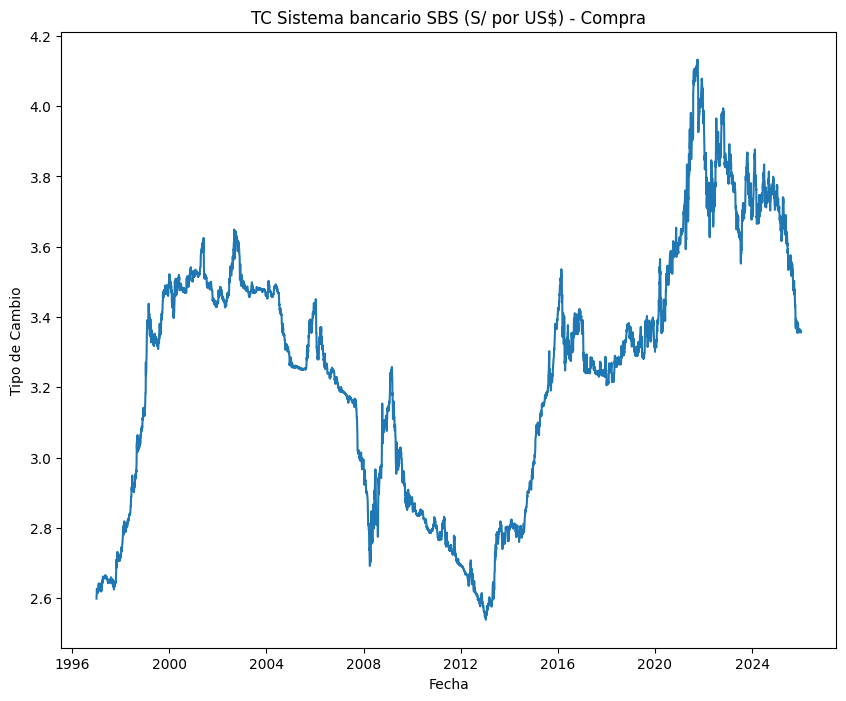

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

# URL de la página web que contiene la tabla
url = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/diarias/resultados/PD04639PD/html'
r = requests.get(url)

# Verificar si la solicitud fue exitosa
if r.status_code == 200:
    # Crear el objeto BeautifulSoup para analizar el contenido HTML
    soup = BeautifulSoup(r.content, 'html.parser')

    # Encontrar la tabla con clase "series"
    table = soup.find('table')

    # Crear listas vacías para almacenar los datos
    periods_new = []
    indices_new = []

    # Extraer los datos de las filas de la tabla
    for row in table.find_all('tr')[1:]:  # Saltar el encabezado
        period = row.find('td', {'class': 'periodo'})
        index = row.find('td', {'class': 'dato'})

        if period and index:
            # Obtener el texto de cada celda y quitar espacios innecesarios
            periods_new.append(period.text.strip())
            indices_new.append(index.text.strip())

    # Crear un DataFrame con los datos extraídos
    df_cambio = pd.DataFrame({'Fecha': periods_new, 'Tipo de Cambio': indices_new})

    # Mostrar el DataFrame
    print(df_cambio)
else:
    print("No se pudo acceder a la página web.")


# Diccionario para mapear nombres de meses en español a números
meses = {
    'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Ago': '08', 'Set': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
}

def convertir_fecha(fecha):
    # Extraer el día, mes y año de la cadena
    dia = fecha[:2]  # Los primeros dos caracteres son el día
    mes_abbr = fecha[2:5]  # Los siguientes tres caracteres son el mes en abreviatura
    año = fecha[5:]  # El resto de la cadena es el año

    # Convertir el año al formato completo
    if int(año) < 50:
        año_completo = '20' + año
    else:
        año_completo = '19' + año

    # Convertir el mes a su formato numérico (01, 02, ..., 12)
    mes = meses.get(mes_abbr)

    # Retornar la fecha en formato YYYY-MM-DD
    return f'{año_completo}-{mes}-{dia}'



df_cambio['Fecha']=df_cambio['Fecha'].apply(convertir_fecha)
df_cambio['Fecha']=pd.to_datetime(df_cambio['Fecha'],format='%Y-%m-%d')
df_cambio['Tipo de Cambio']=pd.to_numeric(df_cambio['Tipo de Cambio'],errors='coerce')
# remplazar valores nulos
df_cambio['Tipo de Cambio'] = df_cambio['Tipo de Cambio'].fillna(method='ffill')
df_cambio.head()

plt.figure(figsize=(10,8))
sns.lineplot(data=df_cambio,x='Fecha',y='Tipo de Cambio')
plt.title('TC Sistema bancario SBS (S/ por US$) - Compra')
plt.show()

df_cambio.to_csv('tipo_cambio.csv', index=False)

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

# URL de la página web que contiene la tabla
url = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/anuales/resultados/PM40026BA/html'
r = requests.get(url)

# Verificar si la solicitud fue exitosa
if r.status_code == 200:
    # Crear el objeto BeautifulSoup para analizar el contenido HTML
    soup = BeautifulSoup(r.content, 'html.parser')

    # Encontrar la tabla con clase "series"
    table = soup.find('table')

    # Crear listas vacías para almacenar los datos
    periods_new = []
    indices_new = []

    # Extraer los datos de las filas de la tabla
    for row in table.find_all('tr')[1:]:  # Saltar el encabezado
        period = row.find('td', {'class': 'periodo'})
        index = row.find('td', {'class': 'dato'})

        if period and index:
            # Obtener el texto de cada celda y quitar espacios innecesarios
            periods_new.append(period.text.strip())
            indices_new.append(index.text.strip())

    # Crear un DataFrame con los datos extraídos
    df_cambio = pd.DataFrame({'Fecha': periods_new, 'Producto Bruto Interno (millones de USD)': indices_new})
    df_cambio['Fecha'] = pd.to_datetime(df_cambio['Fecha'].astype(str), format='%Y')
    df_cambio['Producto Bruto Interno (millones de USD)'] = pd.to_numeric(
    df_cambio['Producto Bruto Interno (millones de USD)'],
    errors='coerce')

    # Mostrar el DataFrame
    print(df_cambio)
else:
    print("No se pudo acceder a la página web.")

df_cambio.to_csv('Producto Bruto Interno.csv', index=False)

        Fecha  Producto Bruto Interno (millones de USD)
0  1950-01-01                                      1025
1  1951-01-01                                      1350
2  1952-01-01                                      1376
3  1953-01-01                                      1408
4  1954-01-01                                      1428
..        ...                                       ...
70 2020-01-01                                    209723
71 2021-01-01                                    229897
72 2022-01-01                                    248546
73 2023-01-01                                    272496
74 2024-01-01                                    295899

[75 rows x 2 columns]


In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

# URL de la página web que contiene la tabla
url = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN38705PM/html'
r = requests.get(url)

# Verificar si la solicitud fue exitosa
if r.status_code == 200:
    # Crear el objeto BeautifulSoup para analizar el contenido HTML
    soup = BeautifulSoup(r.content, 'html.parser')

    # Encontrar la tabla con clase "series"
    table = soup.find('table')

    # Crear listas vacías para almacenar los datos
    periods_new = []
    indices_new = []

    # Extraer los datos de las filas de la tabla
    for row in table.find_all('tr')[1:]:  # Saltar el encabezado
        period = row.find('td', {'class': 'periodo'})
        index = row.find('td', {'class': 'dato'})

        if period and index:
            # Obtener el texto de cada celda y quitar espacios innecesarios
            periods_new.append(period.text.strip())
            indices_new.append(index.text.strip())

    # Crear un DataFrame con los datos extraídos
    df_cambio = pd.DataFrame({'Fecha': periods_new, 'Índice de Precios al Consumidor (IPC)': indices_new})

    # Mostrar el DataFrame
    print(df_cambio)
else:
    print("No se pudo acceder a la página web.")

import pandas as pd

import pandas as pd

# Diccionario de meses
meses = {
    'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Ago': '08', 'Set': '09', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
}

def convertir_fecha(fecha):
    """Convierte 'Ene91' → datetime(1991,1,1)"""
    if not isinstance(fecha, str) or len(fecha) < 5:
        return pd.NaT

    mes_abbr = fecha[:3].capitalize()
    año = fecha[3:]

    if len(año) == 2:
        año = int(año)
        año = 1900 + año if año >= 50 else 2000 + año
    else:
        año = int(año)

    mes = meses.get(mes_abbr)
    if mes is None:
        return pd.NaT

    return pd.to_datetime(f"{año}-{mes}-01", errors='coerce')

# --- Transformaciones finales ---
df_cambio['Fecha'] = df_cambio['Fecha'].apply(convertir_fecha)
df_cambio['Índice de Precios al Consumidor (IPC)'] = (
    df_cambio['Índice de Precios al Consumidor (IPC)']
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Mantener solo las dos columnas ---
df_cambio = df_cambio[['Fecha', 'Índice de Precios al Consumidor (IPC)']]
df_cambio.to_csv('Índice de Precios al Consumidor (IPC).csv', index=False)

     Fecha Índice de Precios al Consumidor (IPC)
0    Ene91                                  7.39
1    Feb91                                  8.09
2    Mar91                                  8.71
3    Abr91                                  9.22
4    May91                                  9.93
..     ...                                   ...
415  Ago25                                115.59
416  Sep25                                115.60
417  Oct25                                115.48
418  Nov25                                115.61
419  Dic25                                115.89

[420 rows x 2 columns]


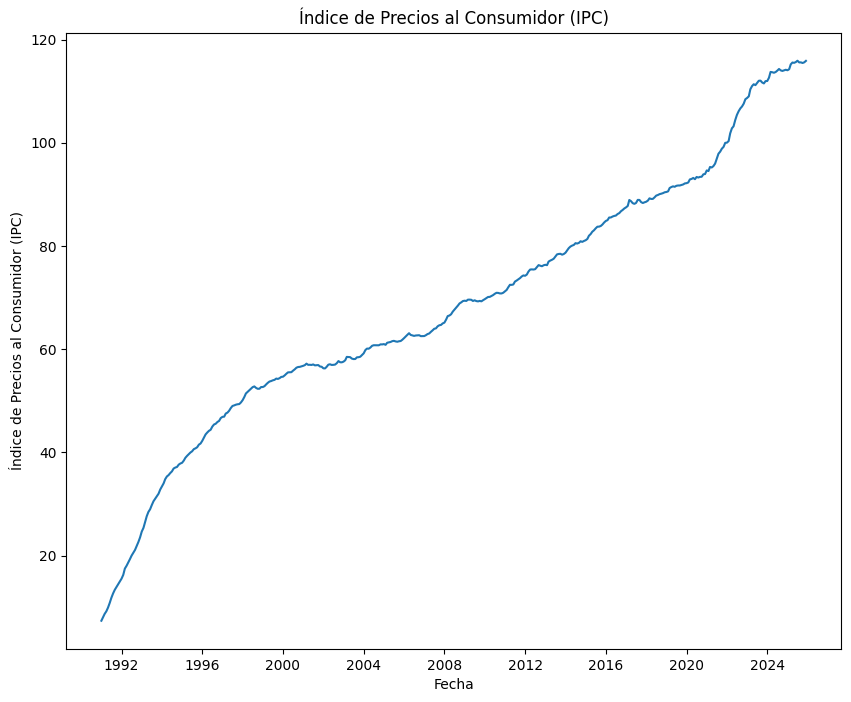

In [11]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df_cambio,x='Fecha',y='Índice de Precios al Consumidor (IPC)')
plt.title('Índice de Precios al Consumidor (IPC)')
plt.show()